In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_04 import *

## Initial setup

In [3]:
x_train, y_train, x_valid, y_valid = get_mnist_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
  return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback(accuracy)])

run.fit(3, learn)

train: [0.656894296875, tensor(0.8082)]
valid: [0.5730484375, tensor(0.8204)]
train: [0.297785234375, tensor(0.9126)]
valid: [0.245348291015625, tensor(0.9283)]
train: [0.2409212890625, tensor(0.9311)]
valid: [0.213889990234375, tensor(0.9402)]


In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback(accuracy)])

run.fit(3, learn)

train: [0.765175859375, tensor(0.7988)]
valid: [0.3580199462890625, tensor(0.9011)]
train: [0.3477602734375, tensor(0.9003)]
valid: [0.29047177734375, tensor(0.9180)]
train: [0.29737685546875, tensor(0.9163)]
valid: [0.2572591796875, tensor(0.9273)]


In [8]:
#export
def get_model_func(lr=0.5):
  return partial(get_model, lr=lr)

## Annealing
We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registerd in the state_dict of the optimizer.

In [9]:
#export
class Recorder(Callback):
  def begin_fit(self):
    self.lrs = []
    self.losses = []
    
  def after_batch(self):
    if not self.in_train:
      return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())
    
  def plot_lr(self):
    plt.plot(self.lrs)
    
  def plot_loss(self):
    plt.plot(self.losses)
    
class ParamScheduler(Callback):
  _order = 1
  
  def __init__(self, pname, sched_func):
    self.pname = pname
    self.sched_func = sched_func
  
  def set_param(self):
    for pg in self.opt.param_groups:
      pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)
    
  def begin_batch(self):
    if self.in_train:
      self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos` = 0) to `end` (at `pos` = 1) in a linear fashion.

In [10]:
def sched_lin(start, end):
  def _inner(start, end, pos):
    return start + pos * (end - start)
  return partial(_inner, start, end)

We can refactor this with a decorator.

In [11]:
#export
def annealer(f):
  def _inner(start, end):
    return partial(f, start, end)
  return _inner

@annealer
def sched_lin(start, end, pos):
  return start + pos * (end - start)

In [12]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [13]:
f = sched_lin(1, 2)
f(0.3)

1.3

And here are other scheduler functions

In [14]:
#export
@annealer
def sched_cos(start, end, pos):
  return start + (1 + math.cos(math.pi * (1 - pos))) * (end - start) / 2

@annealer
def sched_no(start, end, pos):
  return start

@annealer
def sched_exp(start, end, pos):
  return start * (end / start) ** pos

def cos_1cycle_anneal(start, high, end):
  return [sched_cos(start, high), sched_cos(high, end)]

# This monkey-patch is there to be able to plot tensors
# torch.Tensor.ndim = property(lambda x: len(x.shape))

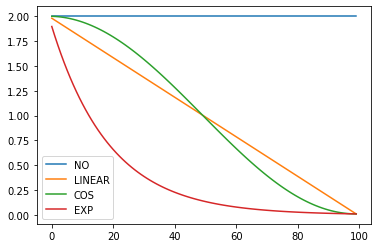

In [15]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
  f = fn(2, 1e-2)
  plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we will often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [16]:
#export
def combine_scheds(pcts, scheds):
  assert sum(pcts) == 1
  pcts = tensor([0] + listify(pcts))
  assert torch.all(pcts >= 0)
  pcts = torch.cumsum(pcts, 0)
  def _inner(pos):
    idx = torch.nonzero(pos >= pcts, as_tuple=False).max()
    if idx == len(pcts) - 1: # Handle boundary case when pos = 1
      idx = len(pcts) - 2
    try:
      actual_pos = (pos - pcts[idx]) / (pcts[idx + 1] - pcts[idx])
    except:
      print(pos, idx)
    return scheds[idx](actual_pos)
  return _inner

In [17]:
sched = combine_scheds([0.3, 0.5, 0.1, 0.1], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2), sched_cos(0.2, 0.3), sched_cos(0.3, 0.2)])

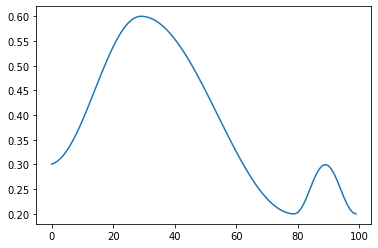

In [18]:
plt.plot(a, [sched(o) for o in p]);

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

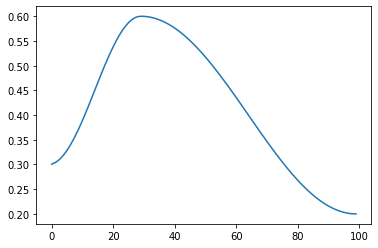

In [20]:
plt.plot(a, [sched(o) for o in p]);

We can use it for training quite easily...

In [21]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [22]:
learn = create_learner(get_model_func(lr=0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
run.fit(3, learn)

train: [0.77469, tensor(0.7808)]
valid: [0.3415122802734375, tensor(0.8989)]
train: [0.2972789453125, tensor(0.9128)]
valid: [0.2360643310546875, tensor(0.9323)]
train: [0.236362265625, tensor(0.9333)]
valid: [0.2085986572265625, tensor(0.9417)]


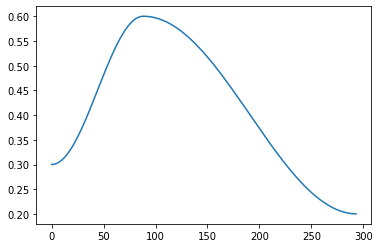

In [24]:
run.recorder.plot_lr()

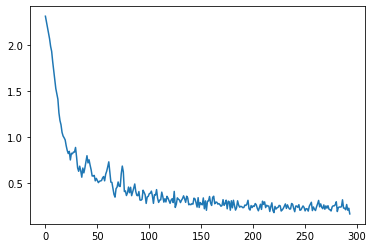

In [25]:
run.recorder.plot_loss()

## Export

In [26]:
!python notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to nb_05.py
